## 1. Задача

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

### Наименование файлов с данными

- `course_project_train.csv` - обучающий датасет
- `course_project_test.csv` - тестовый датасет

### Целевая переменная

`Credit Default` - факт невыполнения кредитных обязательств

### Метрика качества

`F1-score` (sklearn.metrics.f1_score)

### Требования к решению

1. **Целевая метрика**

- F1 > 0.5
- Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

2. **Использовать полный pipline разработки ML-модели**:
- `EDA-анализ` (Разведочный анализ данных)
- `Preprocessing` (предобработка данных)
- `FE` (Генерация признаков - ПРИ НЕОБХОДИМОСТИ (она не обязательно должна быть в рамках этой задачи))
- `Моделирование` (построение baseline модели, подбор гиперпараметров, валидация)

3. **Запушить ноутбук с решением в открытый репозиторий на GitHub и написать понятную документацию в формате README.md с ключевыми выводами**

4. **Повышенный уровень сложности**

- Реализовать самописный алгоритм для логистической регрессии и провести сравнение между метрикой, полученной по `рукописному алгоритму`, и алгоритму `LinearRegression()` из `scikit-learn`

# 2. Описание датасета¶

**Описание каждого признака:**

- `Home Ownership` (Тип жилья): Показывает тип собственности на жилье, например, "Владение", "Аренда" или "Ипотека".
- `Annual Income` (Годовой доход): Отражает годовой доход заемщика в денежном выражении.
- `Years in current job` (Количество лет на текущей работе): Показывает количество лет, которое заемщик проработал на текущем месте работы.
- `Tax Liens` (Налоговые обременения): Отражает наличие налоговых обременений или задолженностей у заемщика.
- `Number of Open Accounts` (Количество открытых счетов): Указывает на общее количество открытых счетов у заемщика, включая кредитные карты, кредитные линии и другие.
- `Years of Credit History` (Количество лет кредитной истории): Показывает общую продолжительность кредитной истории заемщика в годах.
- `Maximum Open Credit` (Максимальная открытая кредитная линия): Отражает максимальную сумму кредитной линии, которая была предоставлена заемщику.
- `Number of Credit Problems` (Количество кредитных проблем): Указывает на количество проблем с кредитом, например, просроченных платежей или коллекций.
- `Months since last delinquent` (Количество месяцев с последней просрочки платежа): Показывает количество месяцев, прошедших с последней просрочки платежа заемщика.
- `Bankruptcies` (Банкротства): Отражает количество банкротств, которые заемщик может иметь в кредитной истории.
- `Purpose` (Цель кредита): Указывает на цель, для которой заемщик берет кредит, например, "автомобиль", "образование" или "недвижимость".
- `Term` (Срок кредита): Показывает срок кредита в месяцах, например, "краткосрочный" или "долгосрочный".
- `Current Loan Amount` (Текущая сумма кредита): Отражает текущую сумму, которую заемщик еще должен выплатить по кредиту.
- `Current Credit` Balance (Текущий кредитный баланс): Указывает на текущий остаток задолженности по кредитам и кредитным линиям.
- `Monthly Debt` (Ежемесячный долг): Показывает сумму ежемесячных платежей по всем задолженностям и кредитам.
- `Credit Score` (Кредитный рейтинг): Отражает кредитный рейтинг заемщика, который оценивает его платежеспособность и кредитный риск.


- `Credit Default` (Кредитный дефолт): **Целевая переменная**, которая указывает, возникнет ли у заемщика дефолт по кредиту (1 - дефолт, 0 - нет).

# 3. Примерное описание этапов выполнения проекта¶

### Построение модели классификации

1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

### Прогнозирование на тестовом датасете

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from scipy import sparse

RANDOM_STATE = 42
TARGET_COL = "Credit Default"

sns.set(style="whitegrid")




# Получение данных

Наша задача — на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту.

In [28]:
train_url = "https://raw.githubusercontent.com/DmitryTeb/hse_lab4_home_task_tebenkov_dm/main/course_project_train.csv"
test_url  = "https://raw.githubusercontent.com/DmitryTeb/hse_lab4_home_task_tebenkov_dm/main/course_project_test.csv"

train_df = pd.read_csv(train_url)
test_df  = pd.read_csv(test_url)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (7500, 17)
Test shape: (2500, 16)


In [29]:
print(train_df[TARGET_COL].value_counts())
print(train_df[TARGET_COL].value_counts(normalize=True))


Credit Default
0    5387
1    2113
Name: count, dtype: int64
Credit Default
0    0.718267
1    0.281733
Name: proportion, dtype: float64


# 1. аккуратный EDA 

In [31]:
# Общая информация
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [32]:
# Пропуски
missing_share = train_df.isna().mean().sort_values(ascending=False)
missing_share.head(10)


Months since last delinquent    0.544133
Credit Score                    0.207600
Annual Income                   0.207600
Years in current job            0.049467
Bankruptcies                    0.001867
Purpose                         0.000000
Monthly Debt                    0.000000
Current Credit Balance          0.000000
Current Loan Amount             0.000000
Term                            0.000000
dtype: float64

In [33]:
# Типы признаков
X = train_df.drop(columns=[TARGET_COL])

cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

print("Количество числовых признаков:", len(num_cols))
print("Количество категориальных признаков:", len(cat_cols))

print("\nЧисловые признаки:")
print(num_cols)

print("\nКатегориальные признаки:")
print(cat_cols)


Количество числовых признаков: 12
Количество категориальных признаков: 4

Числовые признаки:
['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

Категориальные признаки:
['Home Ownership', 'Years in current job', 'Purpose', 'Term']


# Настройка графиков

In [34]:
from pathlib import Path
import matplotlib.pyplot as plt

IMAGES_PATH = Path("images") / "credit_default_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


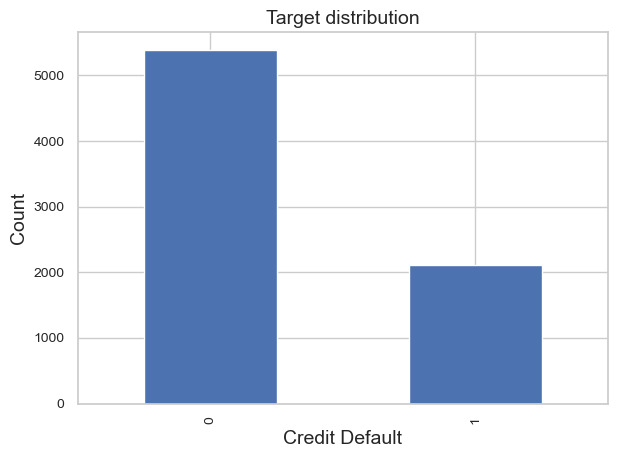

In [35]:
train_df[TARGET_COL].value_counts().plot(kind="bar")
plt.title("Target distribution")
plt.xlabel("Credit Default")
plt.ylabel("Count")
save_fig("target_distribution")
plt.show()


# 2. анализ выбросов

In [36]:
train_df[num_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


In [38]:
from sklearn.base import BaseEstimator, TransformerMixin

class QuantileClipper(BaseEstimator, TransformerMixin):
    def __init__(self, low=0.01, high=0.99):
        self.low = low
        self.high = high
        
    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        self.lower_ = X_df.quantile(self.low)
        self.upper_ = X_df.quantile(self.high)
        return self
    
    def transform(self, X):
        X_df = pd.DataFrame(X)
        X_clipped = X_df.clip(self.lower_, self.upper_, axis=1)
        return X_clipped.values


In [39]:
numeric_pipeline = Pipeline(steps=[
    ("clip", QuantileClipper(low=0.01, high=0.99)),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_cols),
        ("cat", categorical_pipeline, cat_cols)
    ]
)


#  3. Baseline модель (LogisticRegression)

In [41]:
# 3.1 Делим train/valid

X = train_df.drop(columns=[TARGET_COL])
y = train_df[TARGET_COL].astype(int)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train split:", X_train.shape)
print("Valid split:", X_valid.shape)


Train split: (6000, 16)
Valid split: (1500, 16)


In [43]:
# 3.2 Baseline pipeline = preprocess + VarianceThreshold + LogisticRegression

baseline_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("var", VarianceThreshold(threshold=0.0)),
    ("clf", LogisticRegression(
        max_iter=5000,
        class_weight="balanced",
        solver="lbfgs"
    ))
])

baseline_model.fit(X_train, y_train)

y_pred_valid = baseline_model.predict(X_valid)

f1 = f1_score(y_valid, y_pred_valid)
print("Baseline F1-score:", f1)

print("\nClassification report:\n", classification_report(y_valid, y_pred_valid))
print("Confusion matrix:\n", confusion_matrix(y_valid, y_pred_valid))


Baseline F1-score: 0.5452755905511811

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.71      0.77      1077
           1       0.47      0.65      0.55       423

    accuracy                           0.69      1500
   macro avg       0.65      0.68      0.66      1500
weighted avg       0.73      0.69      0.70      1500

Confusion matrix:
 [[761 316]
 [146 277]]


Требование: F1 > 0.5 выполнено.

# 4. Подбор гиперпараметров через GridSearchCV

In [44]:
param_grid = {
    "clf__C": [0.01, 0.1, 1, 10, 30, 100]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(
    baseline_model,
    param_grid=param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV F1:", grid.best_score_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params: {'clf__C': 0.01}
Best CV F1: 0.536748391103064


In [45]:
best_model = grid.best_estimator_

y_pred_valid_best = best_model.predict(X_valid)

f1_best = f1_score(y_valid, y_pred_valid_best)

print("Tuned F1-score:", f1_best)


Tuned F1-score: 0.5350701402805611


# Проверка переобучения

In [46]:
train_pred = baseline_model.predict(X_train)
f1_train = f1_score(y_train, train_pred)

print("F1 train:", f1_train)
print("F1 valid:", f1)


F1 train: 0.5472686455475181
F1 valid: 0.5452755905511811


# 5. подготовка данных для custom модели

In [47]:
# Берём preprocessing из baseline_model
prep = baseline_model.named_steps["preprocess"]
var = baseline_model.named_steps["var"]

X_train_processed = prep.transform(X_train)
X_train_processed = var.transform(X_train_processed)

X_valid_processed = prep.transform(X_valid)
X_valid_processed = var.transform(X_valid_processed)

print("Processed shape:", X_train_processed.shape)


Processed shape: (6000, 44)


# 6. Самописная Logistic Regression (градиентный спуск)|

In [48]:
class CustomLogRegGD:
    def __init__(self, lr=0.2, n_iter=3000, l2=1e-4, random_state=42):
        self.lr = lr
        self.n_iter = n_iter
        self.l2 = l2
        self.random_state = random_state
        self.w_ = None
        self.b_ = 0.0

    @staticmethod
    def _sigmoid(z):
        z = np.clip(z, -35, 35)
        return 1.0 / (1.0 + np.exp(-z))

    def fit(self, X, y, sample_weight=None):
        n, d = X.shape
        rng = np.random.default_rng(self.random_state)
        self.w_ = rng.normal(0.0, 0.01, size=d)
        self.b_ = 0.0

        y = np.asarray(y, dtype=float)
        sw = np.ones(n, dtype=float) if sample_weight is None else np.asarray(sample_weight, dtype=float)

        for _ in range(self.n_iter):
            # z = Xw + b
            z = (X @ self.w_) + self.b_ if sparse.issparse(X) else (X.dot(self.w_) + self.b_)
            p = self._sigmoid(z)

            err = (p - y) * sw

            grad_w = (X.T @ err) / n if sparse.issparse(X) else (X.T.dot(err)) / n
            grad_w = grad_w + self.l2 * self.w_
            grad_b = err.mean()

            self.w_ -= self.lr * grad_w
            self.b_ -= self.lr * grad_b

        return self

    def predict_proba(self, X):
        z = (X @ self.w_) + self.b_ if sparse.issparse(X) else (X.dot(self.w_) + self.b_)
        p = self._sigmoid(z)
        return np.column_stack([1 - p, p])

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X)[:, 1] >= threshold).astype(int)


# 7. обучаем custom модель с балансировкой

In [49]:
# sample_weight как balanced class_weight
classes = np.array([0, 1])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
cw_map = {0: cw[0], 1: cw[1]}
sw_train = np.array([cw_map[int(v)] for v in y_train], dtype=float)

custom = CustomLogRegGD(lr=0.2, n_iter=3000, l2=1e-4, random_state=RANDOM_STATE)
custom.fit(X_train_processed, y_train, sample_weight=sw_train)

# Подбор порога по valid для лучшего F1
proba_valid = custom.predict_proba(X_valid_processed)[:, 1]

thresholds = np.linspace(0.1, 0.9, 81)
best_thr, best_f1 = 0.5, -1

for thr in thresholds:
    pred = (proba_valid >= thr).astype(int)
    f1_thr = f1_score(y_valid, pred)
    if f1_thr > best_f1:
        best_f1, best_thr = f1_thr, thr

print("Custom best F1(valid):", best_f1)
print("Best threshold:", best_thr)


Custom best F1(valid): 0.5454545454545454
Best threshold: 0.49


# Финальный шаг — прогноз на тестовом датасете

# 8. финальный fit + submit для sklearn

In [50]:
# Финальный fit baseline модели на всём train
X_full = train_df.drop(columns=[TARGET_COL])
y_full = train_df[TARGET_COL].astype(int)

baseline_model.fit(X_full, y_full)

test_pred = baseline_model.predict(test_df)

submit = pd.DataFrame({TARGET_COL: test_pred})
print("Submit shape:", submit.shape)
print(submit.head())

submit.to_csv("submit_sklearn.csv", index=False)
print("Saved: submit_sklearn.csv")


Submit shape: (2500, 1)
   Credit Default
0               0
1               0
2               1
3               0
4               0
Saved: submit_sklearn.csv


# 9. финальный submit для custom модели

In [51]:
# Готовим полный preprocess+var заново на всём train
prep_full = baseline_model.named_steps["preprocess"]
var_full = baseline_model.named_steps["var"]

X_full_processed = var_full.transform(prep_full.transform(X_full))
X_test_processed = var_full.transform(prep_full.transform(test_df))

# веса классов на всём train
cw_full = compute_class_weight(class_weight="balanced", classes=np.array([0,1]), y=y_full)
cw_full_map = {0: cw_full[0], 1: cw_full[1]}
sw_full = np.array([cw_full_map[int(v)] for v in y_full], dtype=float)

custom_final = CustomLogRegGD(lr=0.2, n_iter=3000, l2=1e-4, random_state=RANDOM_STATE)
custom_final.fit(X_full_processed, y_full, sample_weight=sw_full)

test_pred_custom = custom_final.predict(X_test_processed, threshold=best_thr)

submit_custom = pd.DataFrame({TARGET_COL: test_pred_custom})
submit_custom.to_csv("submit_custom.csv", index=False)
print("Saved: submit_custom.csv")


Saved: submit_custom.csv
